* ##### Assignment: 3.2 Using Data to improve MLB Attendance
* ##### Name: Barath Anandaraman
* ##### Course: DSC630-T301
* ##### Week3: Data Preparation
* ##### Date: 03/27/2025

---

#### Load necessary packages

In [29]:
# Load libraries
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##### Load the Dodgers data into dataframes using pandas

In [2]:
dodgers_df = pd.read_csv(r"dodgers-2022.csv")

In [3]:
dodgers_df.head(5)

,month,day,attend,day_of_week,opponent,temp,skies,day_night,cap,shirt,fireworks,bobblehead
0,APR,10,56000,Tuesday,Pirates,67,Clear,Day,NO,NO,NO,NO
1,APR,11,29729,Wednesday,Pirates,58,Cloudy,Night,NO,NO,NO,NO
2,APR,12,28328,Thursday,Pirates,57,Cloudy,Night,NO,NO,NO,NO
3,APR,13,31601,Friday,Padres,54,Cloudy,Night,NO,NO,YES,NO
4,APR,14,46549,Saturday,Padres,57,Cloudy,Night,NO,NO,NO,NO


#### Check for datasets NAs, Uniqueness, Duplicates of all column

##### Create a simple loop to find NAs, uniqueness, duplicates for each column from the dataframe

In [4]:
df_state = []
columns = dodgers_df.columns 
for i in columns : 
    types = dodgers_df[i].dtypes
    unique_value = dodgers_df[i].nunique()         
    nan_value= dodgers_df[i].isnull().sum() 
    value_count= dodgers_df[i].isnull().count() 
    nan_percentage= round(nan_value/value_count*100,2)
    duplicated= dodgers_df.duplicated().sum()   
    
    df_state.append ([i , types , unique_value , nan_value, nan_percentage,duplicated])
        
df_state = pd.DataFrame(df_state)
df_state.columns =['Name of column' , 'Types' ,'Unique_data' , 'NAN value', "NAN_percentage","Duplicated"]
df_state.style.highlight_max(color = None, axis = 0)

,Name of column,Types,Unique_data,NAN value,NAN_percentage,Duplicated
0,month,object,7,0,0.000000,0
1,day,int64,31,0,0.000000,0
2,attend,int64,80,0,0.000000,0
3,day_of_week,object,7,0,0.000000,0
4,opponent,object,17,0,0.000000,0
5,temp,int64,32,0,0.000000,0
6,skies,object,2,0,0.000000,0
7,day_night,object,2,0,0.000000,0
8,cap,object,2,0,0.000000,0
9,shirt,object,2,0,0.000000,0


##### All columns do not have missing or duplicated values

#### Check summary statistics

In [5]:
dodgers_df.describe()

,day,attend,temp
count,81.000000,81.000000,81.000000
mean,16.135802,41040.074074,73.148148
std,9.605666,8297.539460,8.317318
min,1.000000,24312.000000,54.000000
25%,8.000000,34493.000000,67.000000
50%,15.000000,40284.000000,73.000000
75%,25.000000,46588.000000,79.000000
max,31.000000,56000.000000,95.000000


* Day values ranges from 1 to 31
* For Attendance, the mean (41,040) is slightly higher than the median (40,284), suggesting a slight positive skew. This means there are some days with unusually high attendance that are pulling the mean upwards.
* Attendance ranges from 24,312 to 56,000. This is a wide range, indicating substantial differences in attendance levels.
* The mean and median temperature (73) is very close, suggesting a fairly symmetrical distribution of temperature.

---

#### Exploratory Data Analysis

#### Check Distribution of attendance

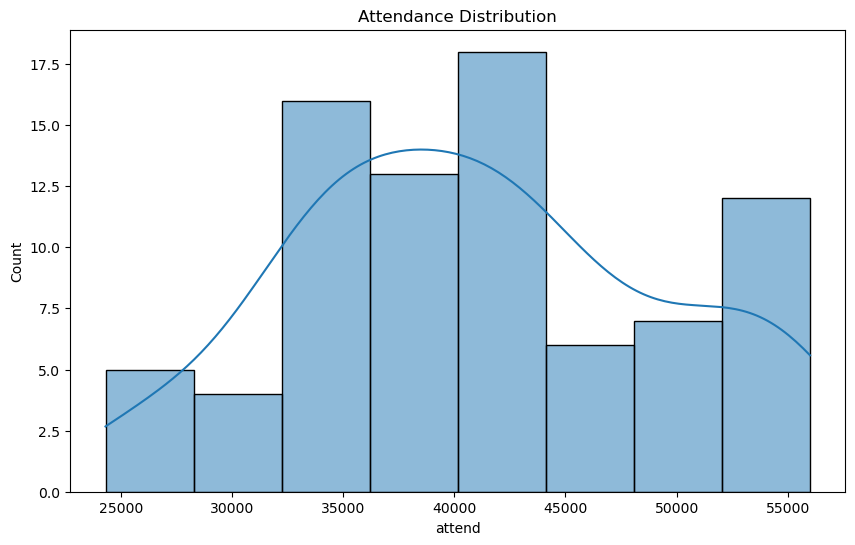

In [6]:
# Attendance Distribution
plt.figure(figsize=(10, 6))
sns.histplot(dodgers_df['attend'], kde=True)
plt.title("Attendance Distribution")
plt.show()


#### Distribution of Attendance shows a somewhat bimodal with 2 peaks between 30,000 to 35,000 and 40,000 to 45,000

#### Check impact of Attendance by Day of Week

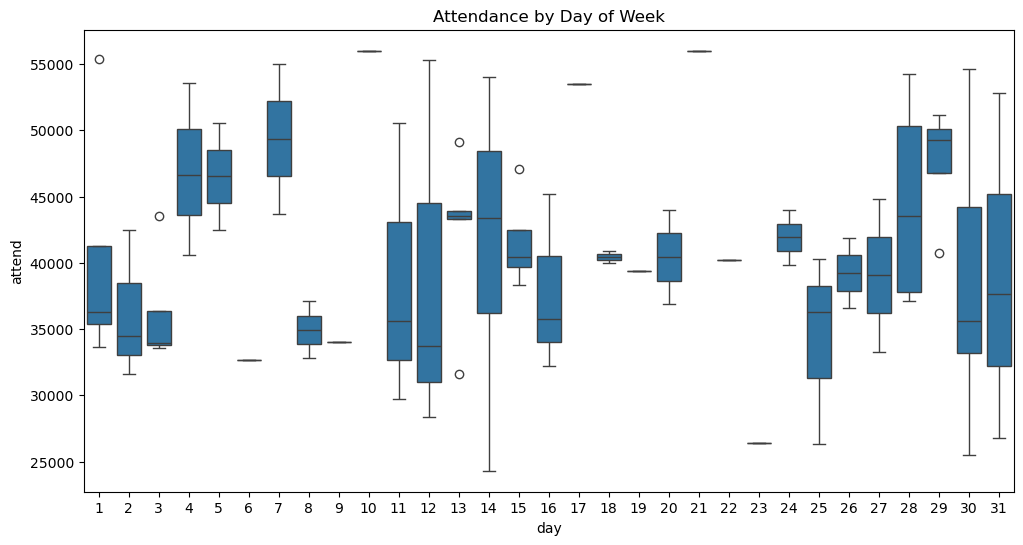

In [7]:
# Attendance by Day of Week
plt.figure(figsize=(12, 6))
sns.boxplot(x='day', y='attend', data=dodgers_df)
plt.title("Attendance by Day of Week")
plt.show()

#### High Attendance is on 4,5, and 7th day 

#### Check impact of Attendance by Month

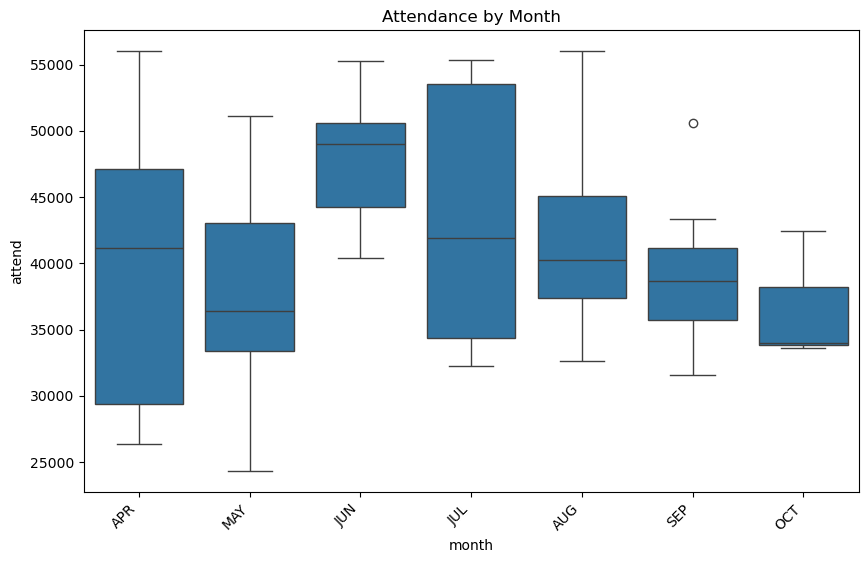

In [11]:
#Attendance by month
plt.figure(figsize = (10,6))
sns.boxplot(x = dodgers_df['month'], y = dodgers_df['attend'])
plt.xticks(rotation = 45, ha = 'right')
plt.title("Attendance by Month")
plt.show()

#### June has highest Attendance followed by July, this could probably be due to school holidays.

#### Check impact of Temperature with Attendance by Opponents

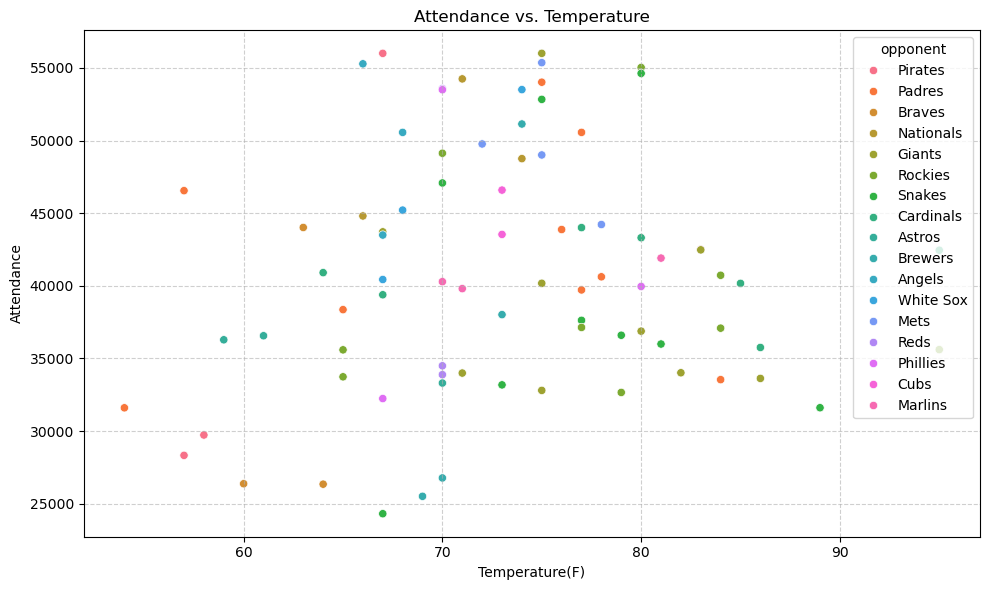

In [38]:
# Create the scatter plot with a trend line for Attendance vs. Temperature
plt.figure(figsize=(10, 6))
#sns.regplot(x='temp', y='attend', data=dodgers_df, scatter_kws={'alpha': 0.5})
sns.scatterplot(data=dodgers_df, x='temp', y='attend', hue='opponent')
plt.title('Attendance vs. Temperature')
plt.xlabel('Temperature(F)')
plt.ylabel('Attendance')
plt.grid(True, linestyle='--', alpha=0.6)  # Add a grid for better readability
plt.tight_layout()
plt.show()

#### Sweet spot is betweeb 65 to 80F for a higher attendance.
#### No correlation to opponents based on temperature

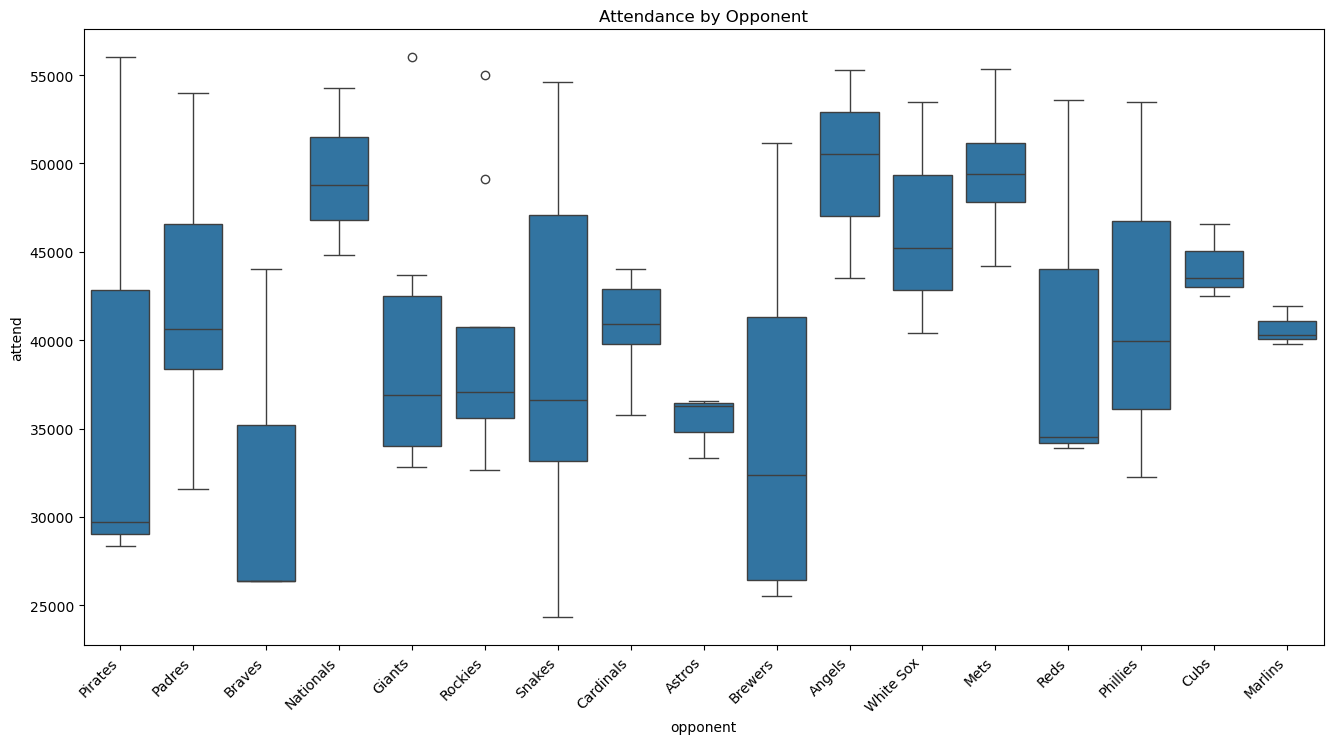

In [8]:
# Attendance by Opponent
plt.figure(figsize=(16, 8))
sns.boxplot(x='opponent', y='attend', data=dodgers_df)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.title("Attendance by Opponent")
plt.show()

#### High Attendance when opponents are Angels, Mets, Nationals and White Sox
#### I will be using the top oppenents as a separate group in future analysis

#### Check impact Promotional Activities

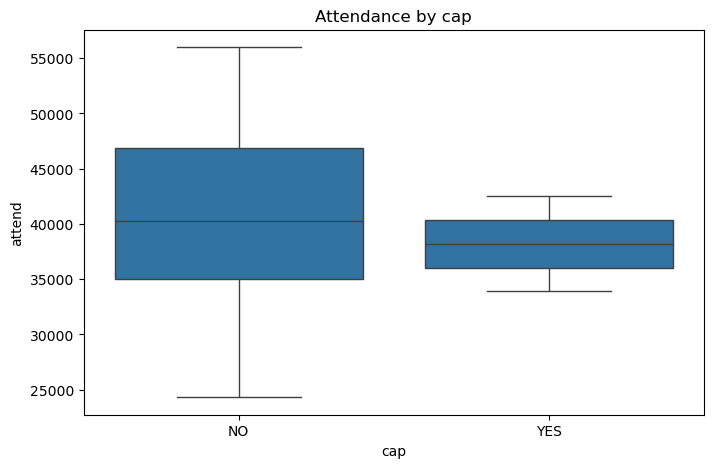

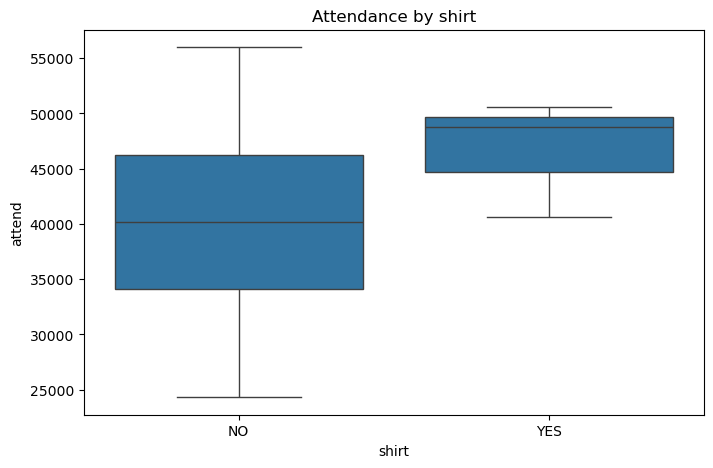

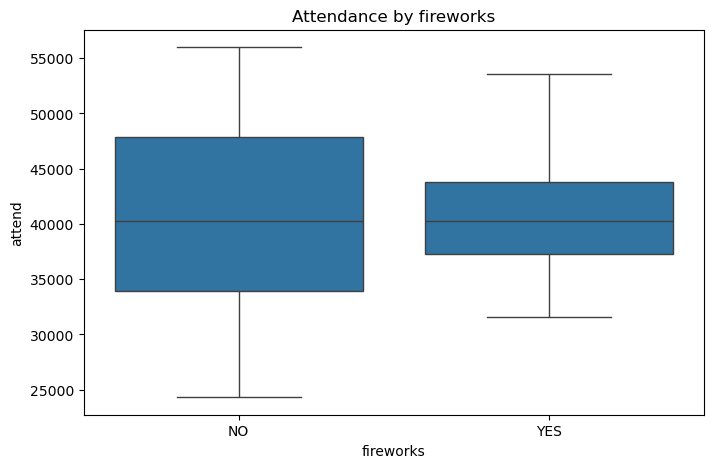

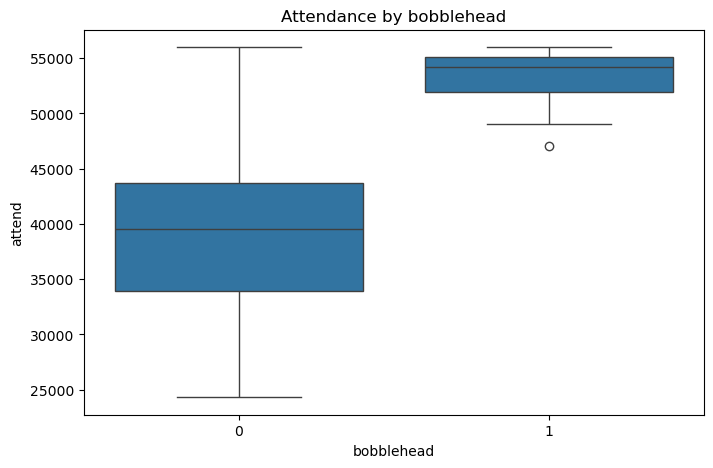

In [43]:
# Attendance by Promotional Events
promotional_cols = ['cap', 'shirt', 'fireworks', 'bobblehead']
for col in promotional_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=col, y='attend', data=dodgers_df)
    plt.title(f"Attendance by {col}")
    plt.show()

#### Very high impact of bobblehead on the Attendance
#### Minor impact of Shirts on the Attendance
#### No impact of Fireworks and Caps on the Attendance

#### Check impact of Day or Night on Attendance

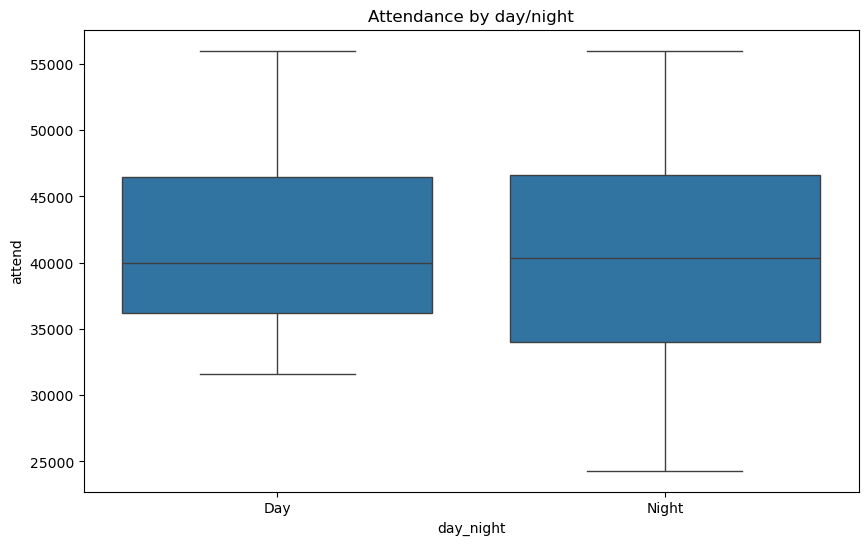

In [12]:
#Attendance by day night
plt.figure(figsize = (10,6))
sns.boxplot(x = 'day_night', y = 'attend', data = dodgers_df)
plt.title("Attendance by day/night")
plt.show()

#### No impact of Day or Night for the Attendance
#### Noticed more lows on Night games

#### Check impact of Attendance the Sky conditions

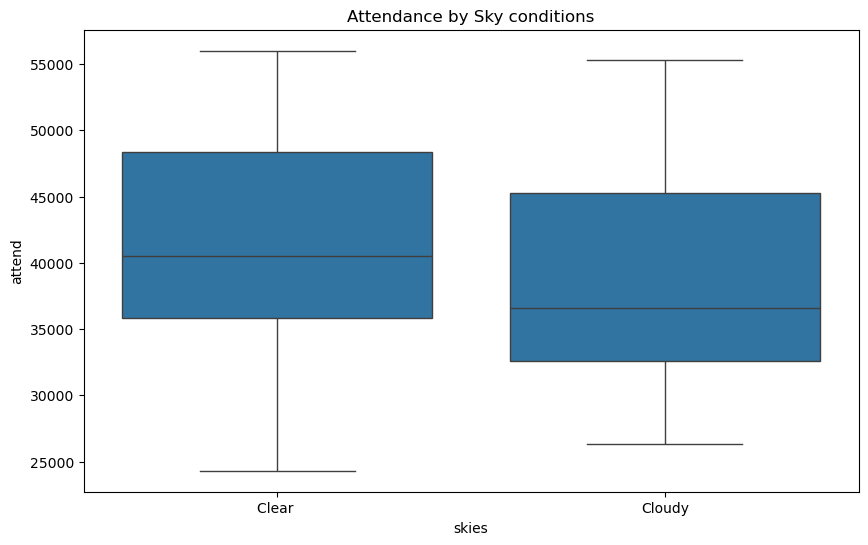

In [13]:
#Attendance by sky conditions
plt.figure(figsize = (10,6))
sns.boxplot(x = 'skies', y = 'attend', data = dodgers_df)
plt.title("Attendance by Sky conditions")
plt.show()

#### Clear Sky has a minor impact on Attendance than cloudy condition

#### Encode some interesting variables found from EDA for correlation

In [15]:
# Day/Night Encoding
dodgers_df['day_night'] = dodgers_df['day_night'].map({'Day': 0, 'Night': 1})

In [16]:
# bobblehead Encoding
dodgers_df['bobblehead'] = dodgers_df['bobblehead'].map({'NO': 0, 'YES': 1})

In [25]:
# Mapping dictionary for Opponents who had very high Attendance
mapping = {'Nationals': 1, 'Angels': 1, 'White Sox': 1, 'Mets': 1}
# Use map with a default value using .get() or a lambda function
dodgers_df['topopponent'] = dodgers_df['opponent'].map(lambda x: mapping.get(x, 0))


In [26]:
# Check output after encoding the columns
dodgers_df.head()

,month,day,attend,day_of_week,opponent,temp,skies,day_night,cap,shirt,fireworks,bobblehead,topopponent
0,APR,10,56000,Tuesday,Pirates,67,Clear,0,NO,NO,NO,0,0
1,APR,11,29729,Wednesday,Pirates,58,Cloudy,1,NO,NO,NO,0,0
2,APR,12,28328,Thursday,Pirates,57,Cloudy,1,NO,NO,NO,0,0
3,APR,13,31601,Friday,Padres,54,Cloudy,1,NO,NO,YES,0,0
4,APR,14,46549,Saturday,Padres,57,Cloudy,1,NO,NO,NO,0,0


#### Check Correlation Matrix on the interested fields like 'temp','day','bobblehead', 'topopponent', 'day_night' on Attendance

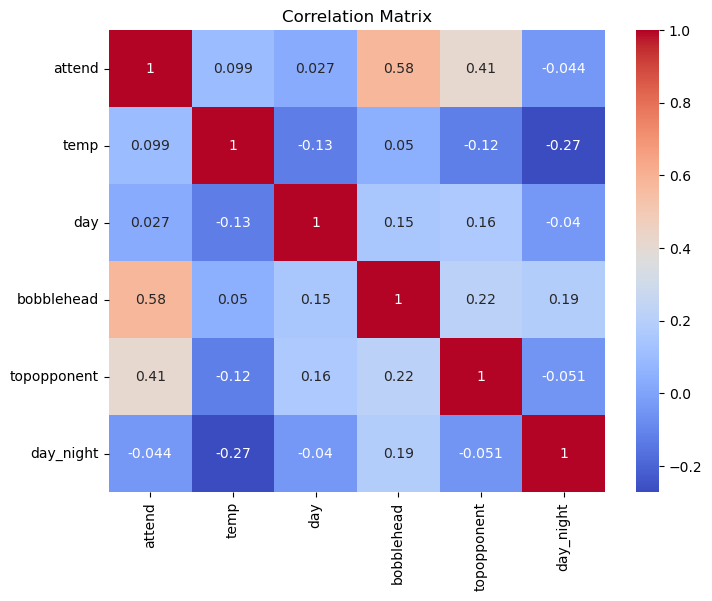

In [44]:
numeric_cols = ['attend', 'temp','day','bobblehead', 'topopponent', 'day_night']  # Add other numeric columns
correlation_matrix = dodgers_df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

#### Results of Coefficient Matrix
* ##### bobblehead has high correlation with 0.58, followed by topopponent of 0.41
* ##### Temperature and day has slightly weak positive correlation of 0.099 and 0.027 respectively
* ##### Day/night has weak negative correlation of -0.044

#### Cross validate using Linear Regression model to check the impact coefficient

In [46]:
# Features and Target
features = ['temp', 'bobblehead', 'topopponent', 'day', 'day_night']
target = 'attend'

# Linear Regression Model
model = LinearRegression()

# Cross-Validation Predictions
predictions = cross_val_predict(model, dodgers_df[features], dodgers_df[target], cv=10) # 10 Fold Cross Validation.

# Fit the model on the entire dataset to get coefficients
model.fit(dodgers_df[features], dodgers_df[target])
coefficients = model.coef_

# Quantifying Impact
print(f"Temperature Coefficient: {coefficients[0]:.2f}")
print(f"Bobblehead Coefficient: {coefficients[1]:.2f}")
print(f"Top Opponent Coefficient: {coefficients[2]:.2f}")
print(f"Day of Month Coefficient: {coefficients[3]:.2f}")
print(f"Day/Night Coefficient: {coefficients[4]:.2f}")

Temperature Coefficient: 64.87
Bobblehead Coefficient: 13171.15
Top Opponent Coefficient: 6973.64
Day of Month Coefficient: -85.85
Day/Night Coefficient: -2489.83


#### Results from 10 fold Cross Validation
* #### Bobblehead is having highest coefficient which suggests that a bobblehead giveaway is associated with 13,171 increase in attendance on average.
* #### Top opponents like Nationals, Angels, White Sox, Mets have likely increase of 6,973 attendance on average
* #### Night games are popular with a likely increase of 2,489 attendance on average

----

### Summary
#### To increase attendance, a promotion of bobblehead has to be given on a night game and it has to be played against one of Nationals, Angels, White Sox, Mets and the game has to be conducted in the month of June on the days of 4,5 or 7.